# Existing finestructure estimates

1. Whalen's estimates are in pretty large bins 250-500m; 500m-1000m; 1000m-2000m; and there's lot of data missing in the NATRE region

In [215]:
import cf_xarray
import dcpy
import gsw
import matplotlib as mpl
import mixsea
import pandas as pd
import scipy
import scipy.integrate
import seawater as sw
from scipy import signal
from scipy.io import loadmat

import xarray as xr

mpl.rcParams["figure.dpi"] = 140
dirname = "/home/deepak/datasets/finestructure/"

## Whalen

Sneakily taken from acknowledgments of Trossman et al (2020)

In [2]:
K = []
for z, name in zip((375, 750, 1500), ["250to500m", "500to1000m", "1000to2000m"]):
    mat = loadmat(f"{dirname}/whalen/av_world_K_{name}_3_1p5deg_2015.mat")
    K.append(
        xr.DataArray(
            mat["c"],
            dims=("lat", "lon"),
            coords={"lat": mat["y"].squeeze(), "lon": mat["x"].squeeze(), "z": z},
        )
    )

K = xr.concat(K, dim="z").cf.guess_coord_axis()
K.z.attrs["units"] = "m"
K.to_netcdf(f"{dirname}/whalen2015.nc")
K

<xarray.DataArray (z: 3, lat: 101, lon: 241)>
array([[[1.14926924e-03, 1.87404820e-03,            nan, ...,
         1.73270825e-03, 1.19684959e-04, 4.04780348e-04],
        [4.61545906e-05, 3.77968734e-05, 2.20720928e-03, ...,
                    nan, 8.46056775e-05, 2.20150150e-05],
        [           nan, 3.64251173e-05, 2.34609923e-05, ...,
         1.72037751e-05, 1.85861537e-04, 9.51779934e-06],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[6.74521750e-04, 1.62954533e-04,            nan, ...,
         1.75821579e-04, 9.47196336e-06, 1.19420112e-05],
        [           nan,            nan, 1.19879684e-04, ...,
                    nan, 2.72826324e-05,            nan],
        [1.36392184e-05, 4.14167208e-05, 4.26732736e-05, ...,
                    nan, 1.34894389e-04, 1.08020983e-05],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan, 5.37029196e-06, 2.99769652e-05, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * lat      (lat) float64 75.0 73.5 72.0 70.5 69.0 ... -70.5 -72.0 -73.5 -75.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5 360.0
  * z        (z) int64 375 750 1500

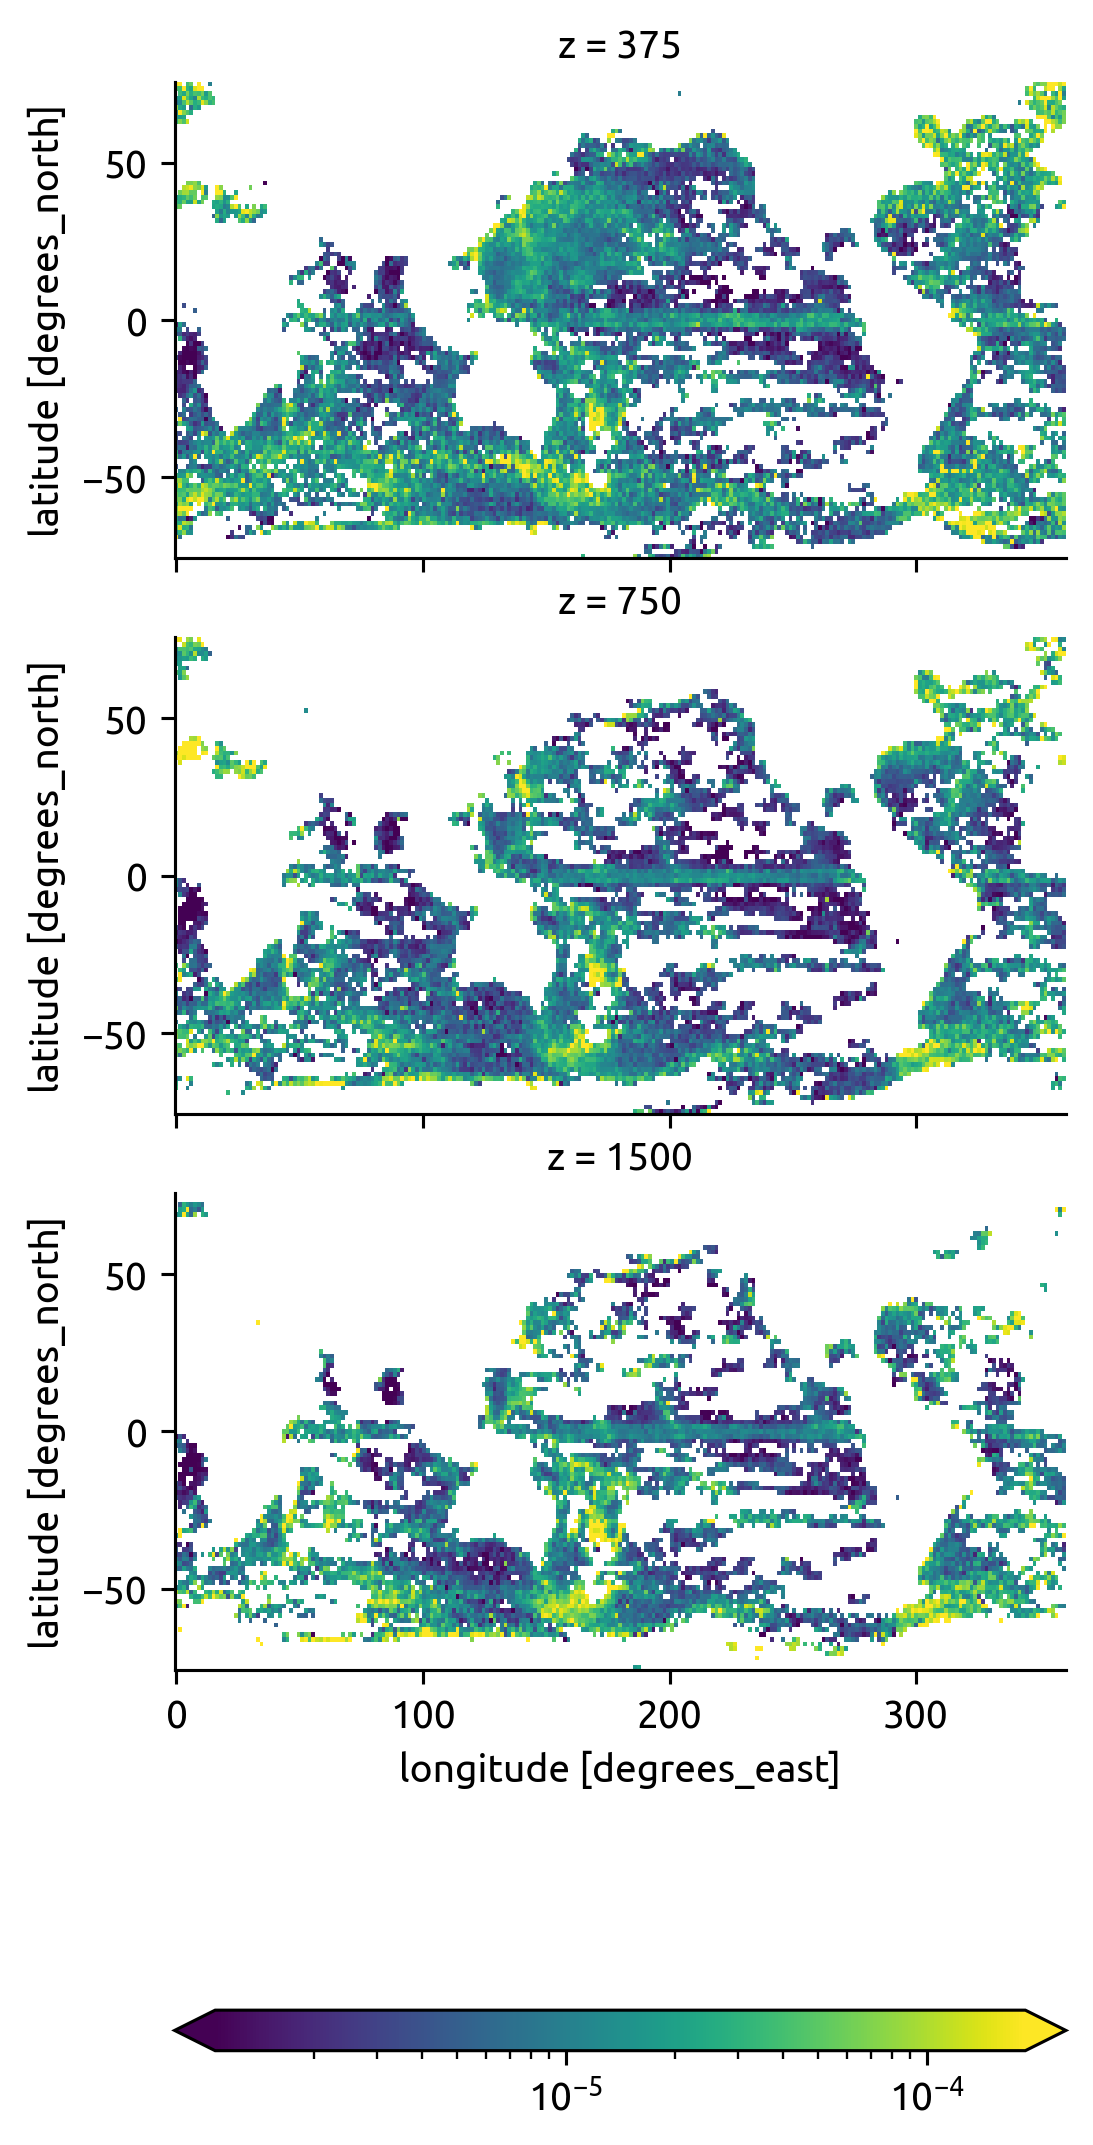

In [3]:
K.plot(
    row="z",
    norm=mpl.colors.LogNorm(),
    robust=True,
    cbar_kwargs={"orientation": "horizontal"},
)

## Kunze

The remaining lines list

- hydrographic section name,
- the drop number,
- latitude,
- longitude,
- bounding depths z_i and z_f,
- bounding neutral densities,
- buoyancy frequency squared N^2,
- dissipation rate (W/kg)
- diapycnal diffusivity K (m^2/s).

In [803]:
kunze = dcpy.oceans.read_kunze_2017_finestructure()

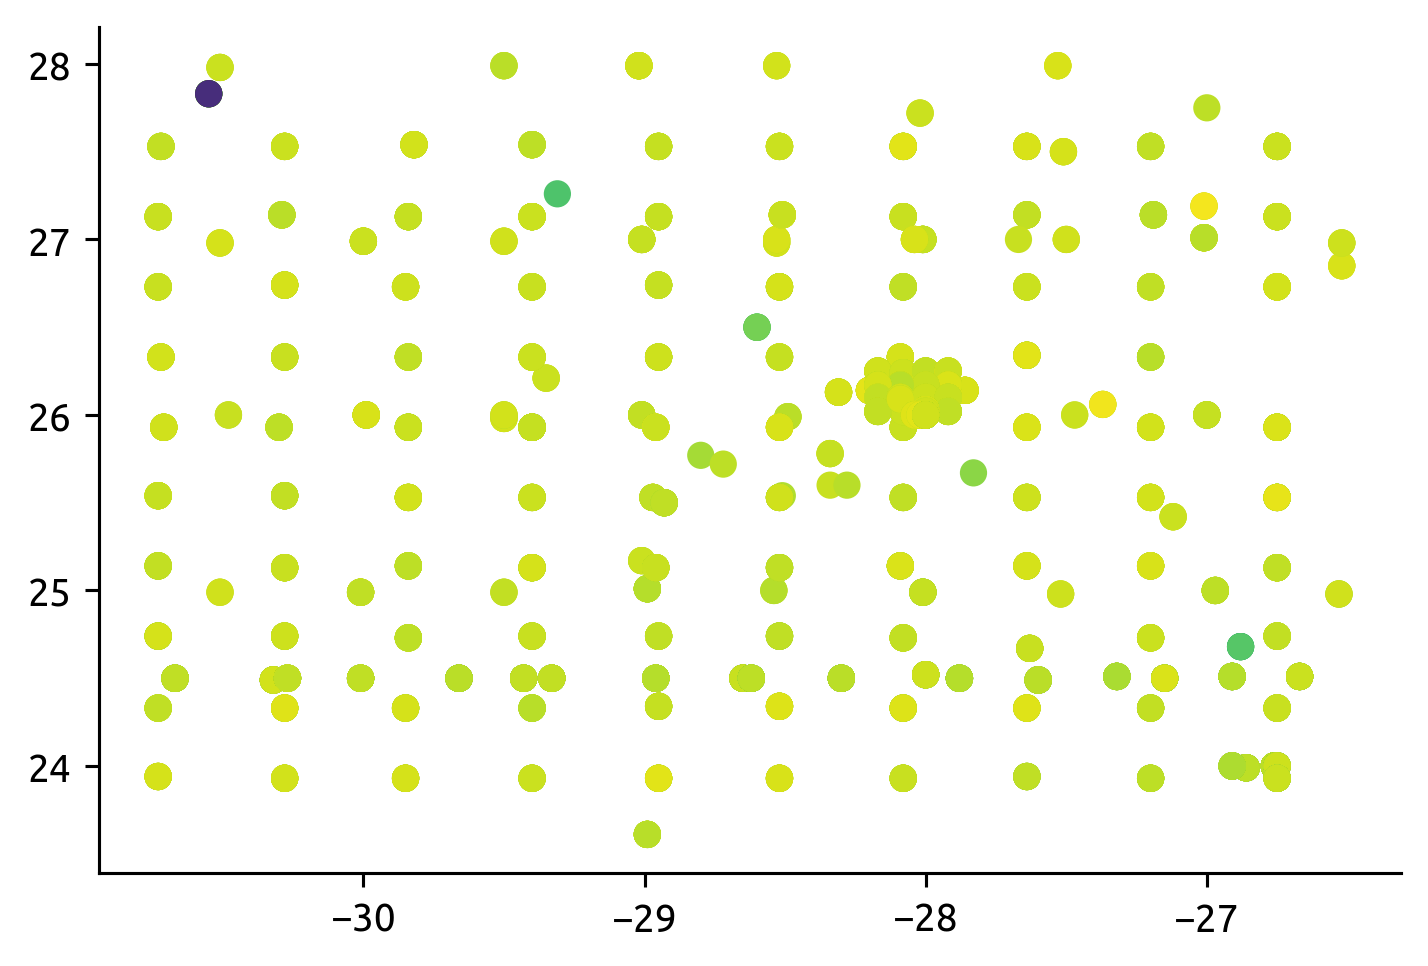

In [804]:
natre_fs = kunze.query(
    "longitude > -31 & longitude < -26.5 & latitude > 23.5 & latitude < 28"
)

import matplotlib.pyplot as plt
import numpy as np

plt.scatter(natre_fs["longitude"], natre_fs["latitude"], c=np.log10(natre_fs["ε"]))

In [805]:
factorized = pd.cut(
    kunze.γ_mean,
    bins=[
        26.692,
        26.876,
        27.039,
        27.163,
        27.288,
        27.406,
        27.516,
        27.605,
        27.683,
        27.742,
        27.794,
        27.835,
        27.872,
        27.898,
        27.921,
        27.94,
        27.958,
    ],
)
binned = kunze.groupby(factorized).mean()
binned.index = binned["γ_mean"]
binned = binned.to_xarray().set_coords("z_mean")
binned

<xarray.Dataset>
Dimensions:    (γ_mean: 16)
Coordinates:
  * γ_mean     (γ_mean) float64 26.79 26.96 27.1 27.23 ... 27.91 27.93 27.95
    z_mean     (γ_mean) float64 -399.5 -438.7 -487.1 ... -1.569e+03 -1.728e+03
Data variables:
    drop       (γ_mean) float64 57.68 58.92 58.71 55.09 ... 50.61 51.6 51.83
    latitude   (γ_mean) float64 3.025 4.287 6.493 11.97 ... 28.51 28.81 27.91
    longitude  (γ_mean) float64 -35.37 -31.95 -31.62 ... -33.96 -33.79 -34.44
    z_i        (γ_mean) float64 -271.9 -311.8 -361.2 ... -1.443e+03 -1.602e+03
    z_f        (γ_mean) float64 -527.1 -565.6 -613.0 ... -1.696e+03 -1.854e+03
    γ_i        (γ_mean) float64 26.55 26.75 26.94 27.11 ... 27.89 27.91 27.93
    γ_f        (γ_mean) float64 27.04 27.18 27.27 27.35 ... 27.93 27.95 27.97
    N2         (γ_mean) float64 1.579e-05 1.352e-05 ... 1.104e-06 9.568e-07
    ε          (γ_mean) float64 2.353e-09 1.943e-09 ... 2.236e-10 1.829e-10
    K          (γ_mean) float64 3.272e-05 3.275e-05 ... 5.24e-05 4.898e-05

This looks encouraging; ε is elevated in the same depth range where χ is elevated

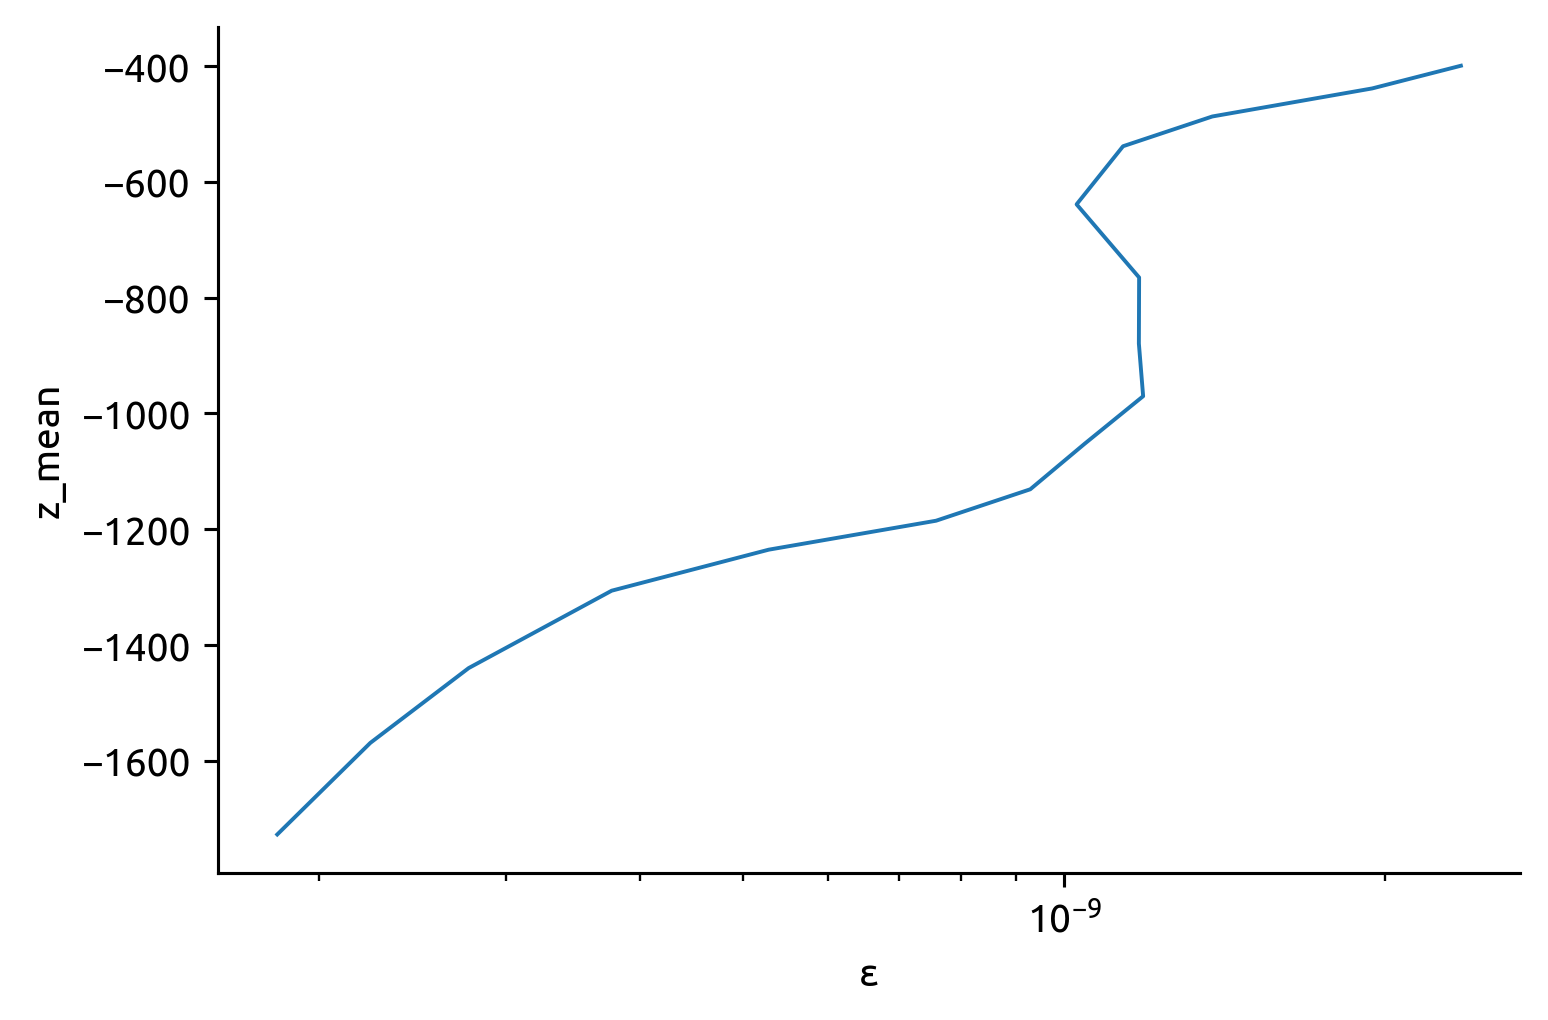

In [7]:
binned.ε.plot(y="z_mean", xscale="log")

In [8]:
kunze.groupby("cruise").count()

,drop,latitude,longitude,z_i,z_f,γ_i,γ_f,N2,ε,K,z_mean,γ_mean
cruise,,,,,,,,,,,,
06AQ19860627,189,189,128,189,189,189,189,189,189,189,189,189
06AQ19931212,502,502,446,502,502,502,502,502,502,502,502,502
317519930704,2117,2117,2117,2117,2117,2117,2117,2117,2117,2117,2117,2117
32OC20080510,270,270,270,270,270,270,270,270,270,270,270,270
64PE20050907,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163
...,...,...,...,...,...,...,...,...,...,...,...,...
ar24_b,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955,1955
ar25_h,496,496,496,496,496,496,496,496,496,496,496,496
atas1,85,85,85,85,85,85,85,85,85,85,85,85
